## Задание 1.

У нас есть данные А/А-теста с '2023-12-22' по '2023-12-28'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования. При выполнении задания важно обосновать и аргументировать ваш вывод.

4. Пришлите ссылку на merge request c проведенным анализом.

### 1. Подготовка к работе

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.simplefilter("ignore")

### 2. Загрузка данных

In [2]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240120',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
# Запрос к БД
query = '''
SELECT user_id,
       exp_group,
       countIf(user_id, action = 'like' ) as like,
       countIf(user_id, action = 'view' ) as view,
       like/view as ctr
FROM simulator_20240120.feed_actions
WHERE (toDate(time) >= '2023-12-22' AND toDate(time) <= '2023-12-28' 
AND exp_group in [2,3])
GROUP BY user_id, exp_group
'''

# Создание датафрейма
df = pandahouse.read_clickhouse(query, connection=connection)

df

,user_id,exp_group,like,view,ctr
0,115383,3,38,248,0.15
1,10326,3,24,132,0.18
2,123580,3,25,122,0.20
3,131473,2,19,98,0.19
4,23985,2,12,44,0.27
...,...,...,...,...,...
16782,122008,3,20,123,0.16
16783,25383,2,2,18,0.11
16784,122190,3,15,56,0.27
16785,108927,2,16,51,0.31


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16787 entries, 0 to 16786
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    16787 non-null  uint32 
 1   exp_group  16787 non-null  int8   
 2   like       16787 non-null  uint64 
 3   view       16787 non-null  uint64 
 4   ctr        16787 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 475.5 KB


### 3. Анализ данных

Распределения для 2й и 3й экспериментальной группы

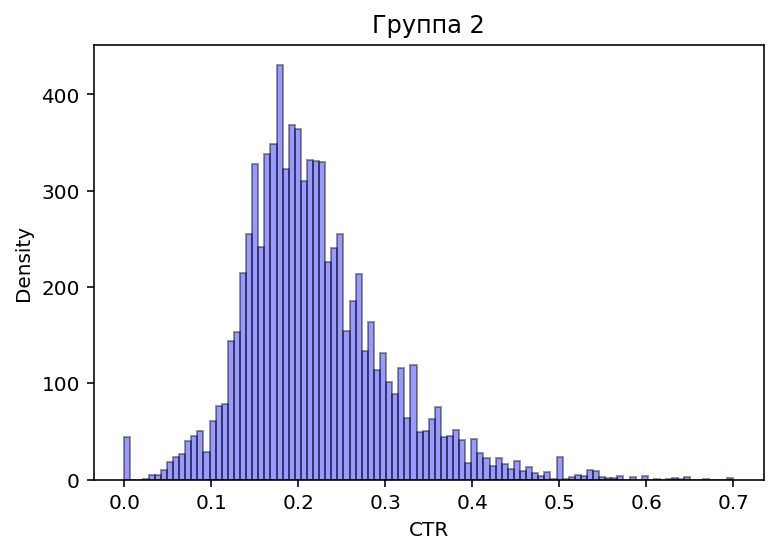

In [5]:
# Распределение экспериментальной группы 2
sns.distplot(df[df.exp_group == 2].ctr, hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Группа 2')
plt.xlabel('CTR')
plt.ylabel('Density');

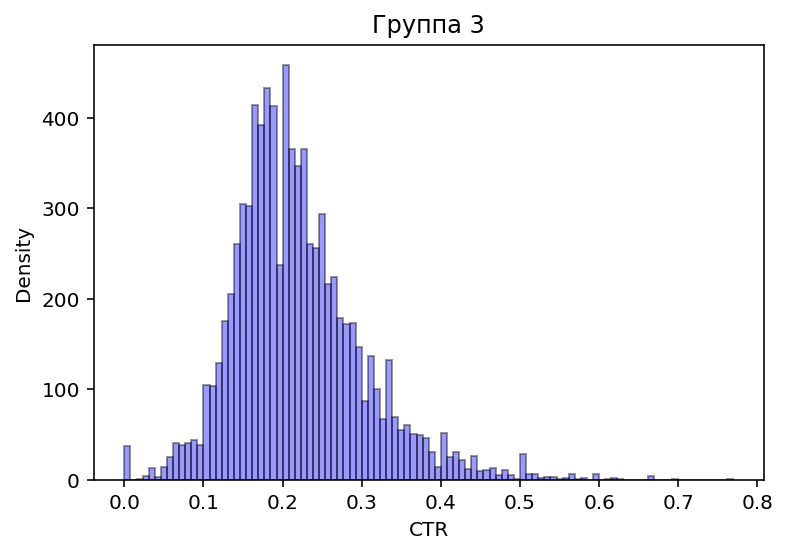

In [6]:
# Распределение экспериментальной группы 3
sns.distplot(df[df.exp_group == 3].ctr, hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Группа 3')
plt.xlabel('CTR')
plt.ylabel('Density');

Xарактер распределения и медиана схожие. В целом явных визуальных различий в распределениях между экспериментальными группами не замечено.

In [7]:
%%time

# Проводим выборку с повторениями в экспериментальных группах 2 и 3
count_tests = 10000
n_samples = 500
p_val_list = []
for i in range(count_tests):
    first_group = df[df.exp_group == 2].ctr.sample(n_samples, replace=True)
    secong_group = df[df.exp_group == 3].ctr.sample(n_samples, replace=True)
    p_value = stats.ttest_ind(first_group, secong_group, equal_var = False)[1]
    p_val_list.append(p_value)

CPU times: user 23.9 s, sys: 0 ns, total: 23.9 s
Wall time: 24.2 s


**Задача 1. Диаграмма p-value.**

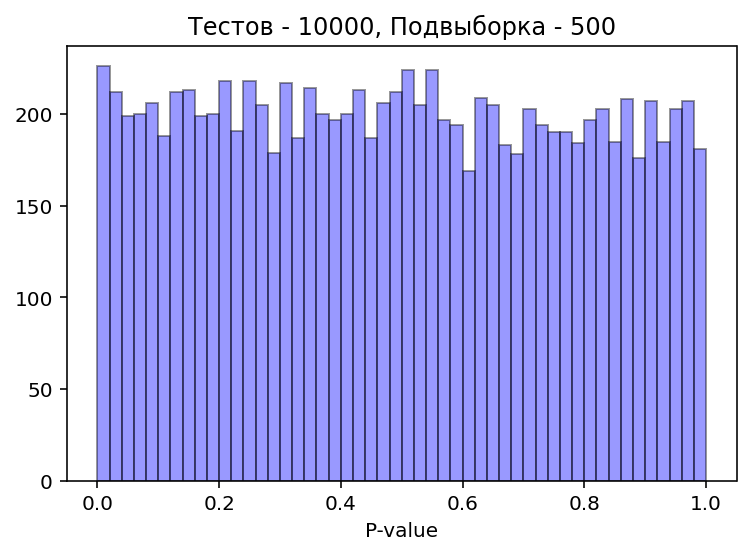

In [8]:
# тестов 10000, подвыборка 500
sns.distplot(pd.Series(p_val_list), hist=True, kde=False, 
             bins=50, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Тестов - 10000, Подвыборка - 500')
plt.xlabel('P-value');

**Задача 2. Процент случаев, когда p-values меньше либо равен 0.05**

In [9]:
percent = round((pd.Series(p_val_list) <= 0.05).sum() / len(p_val_list)*100, 3)
print('Процент случаев, когда p-value меньше либо равен 0.05 - ',
      round((pd.Series(p_val_list) <= 0.05).sum() / len(p_val_list)*100, 3), '%')

Процент случаев, когда p-value меньше либо равен 0.05 -  5.35 %


**Задача 3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.** 

In [10]:
print(f'''Вывод:
Полученная гистограмма позволяет сделать вывод, что p-value распределено равномерно. А при проверке системы 
сплитования было установлено, что в {percent} % случаях p-value меньше или равно заданному порогу альфа 0.05.
Значит система сплитования работает корректно и только в {percent} % случаев у нас бы получались 
статистически значимые различия между 2 и 3 группой.''')

Вывод:
Полученная гистограмма позволяет сделать вывод, что p-value распределено равномерно. А при проверке системы 
сплитования было установлено, что в 5.35 % случаях p-value меньше или равно заданному порогу альфа 0.05.
Значит система сплитования работает корректно и только в 5.35 % случаев у нас бы получались 
статистически значимые различия между 2 и 3 группой.


#### Проверка процента p-value < 0.05 в зависимости от количества наблюдений

### Сравнение с помощью Т - теста.

In [11]:
def check_split(n_samples, n_tests = 10000):
    p_val_list = []
    for i in range(n_tests):
        first_group = df[df.exp_group == 2].ctr.sample(n_samples, replace=True)
        secong_group = df[df.exp_group == 3].ctr.sample(n_samples, replace=True)
        p_value = stats.ttest_ind(first_group, secong_group, equal_var = False)[1]
        p_val_list.append(p_value)
    print('\033[34m\033[1m Прокрас AA-теста: \033[0m %0.2f' % round((pd.Series(p_val_list) <= 0.05).sum() / len(p_val_list) * 100, 3), '%')
    sns.distplot(pd.Series(p_val_list), hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})
    # Add labels
    plt.title(f'Тестов - {n_tests}, Подвыборка - {n_samples}')
    plt.xlabel('P-value');

 Прокрас AA-теста:  4.85 %


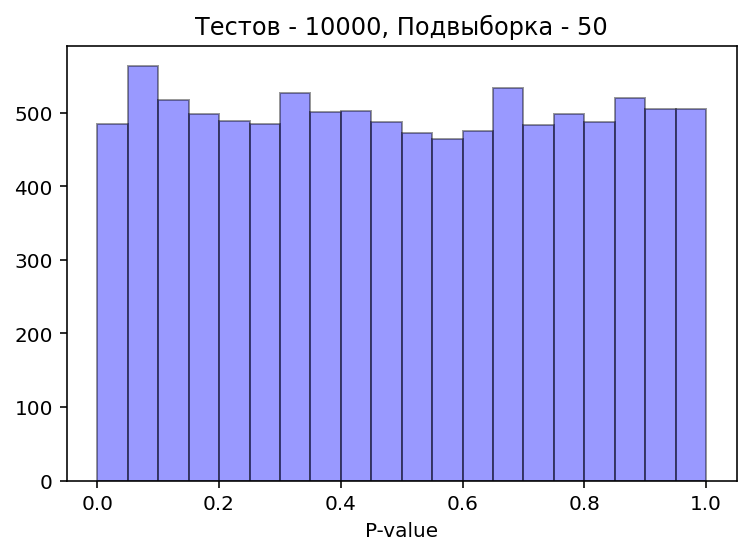

In [12]:
check_split(n_samples = 50, n_tests = 10000)

 Прокрас AA-теста:  5.44 %


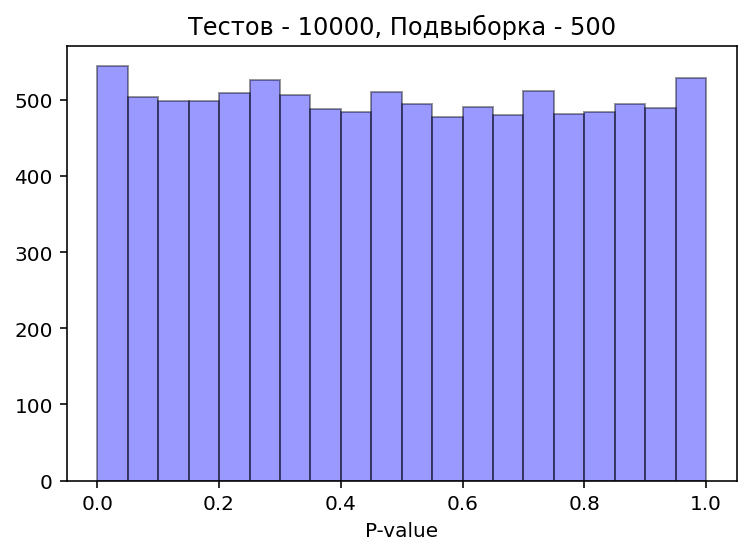

In [13]:
check_split(n_samples = 500, n_tests = 10000)

 Прокрас AA-теста:  5.07 %


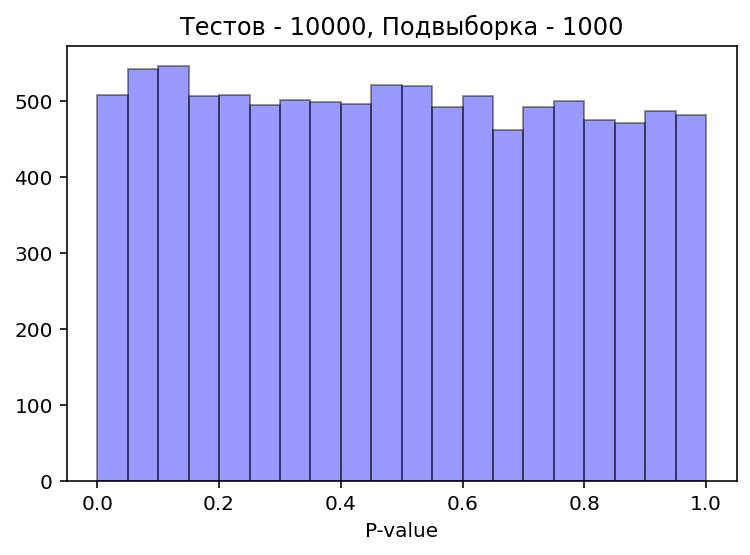

In [14]:
check_split(n_samples = 1000, n_tests = 10000)

 Прокрас AA-теста:  8.24 %


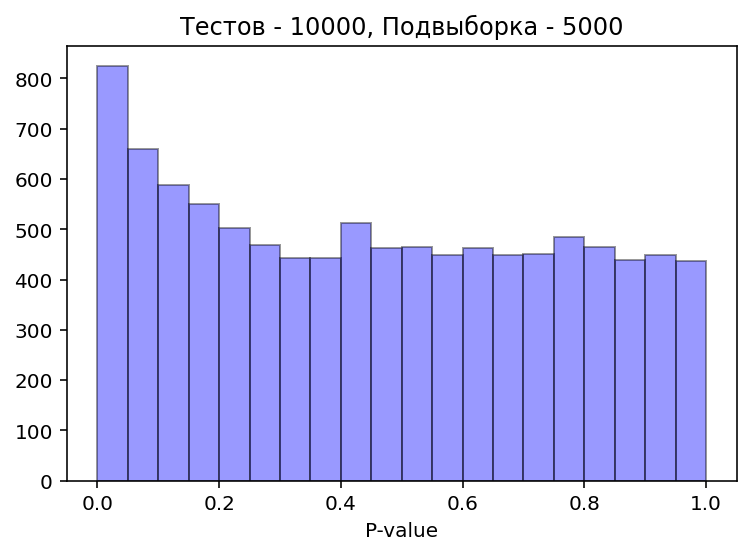

In [15]:
check_split(n_samples = 5000, n_tests = 10000)

При использовании Т-теста видим увеличение процента прокраса АА-теста при увеличении количества сэмплов.

### Сравнение с помощью теста Манна-Уитни.

In [16]:
def check_split_MW(n_samples, n_tests = 10000):
    p_val_list = []
    for i in range(n_tests):
        first_group = df[df.exp_group == 2].ctr.sample(n_samples, replace=True)
        secong_group = df[df.exp_group == 3].ctr.sample(n_samples, replace=True)
        p_value = stats.mannwhitneyu(first_group, secong_group)[1]
        p_val_list.append(p_value)
    print('\033[34m\033[1m Прокрас AA-теста: \033[0m %0.2f' % round((pd.Series(p_val_list) <= 0.05).sum() / len(p_val_list) * 100, 3), '%')
    sns.distplot(pd.Series(p_val_list), hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})
    # Add labels
    plt.title(f'Тестов - {n_tests}, Подвыборка - {n_samples}')
    plt.xlabel('P-value');

 Прокрас AA-теста:  4.78 %


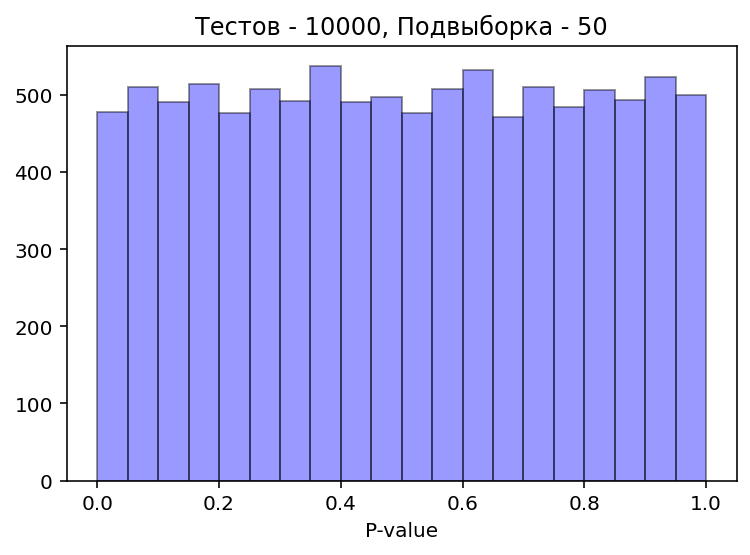

In [17]:
check_split_MW(n_samples = 50, n_tests = 10000)

 Прокрас AA-теста:  5.01 %


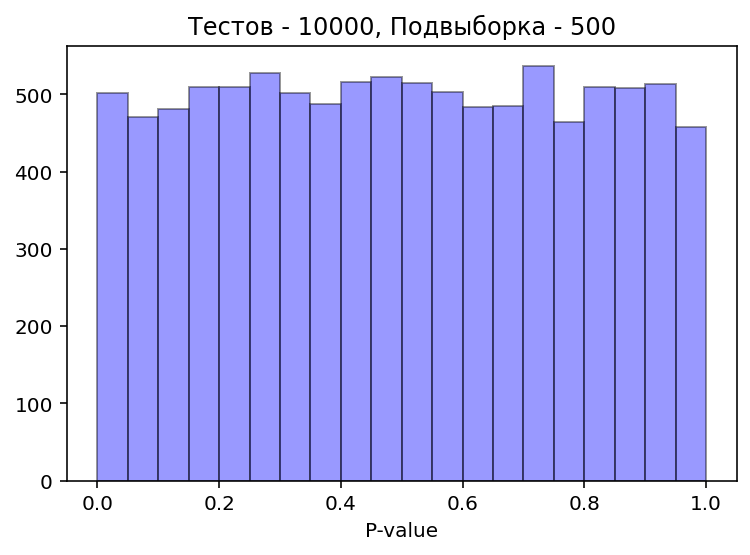

In [18]:
check_split_MW(n_samples = 500, n_tests = 10000)

 Прокрас AA-теста:  5.21 %


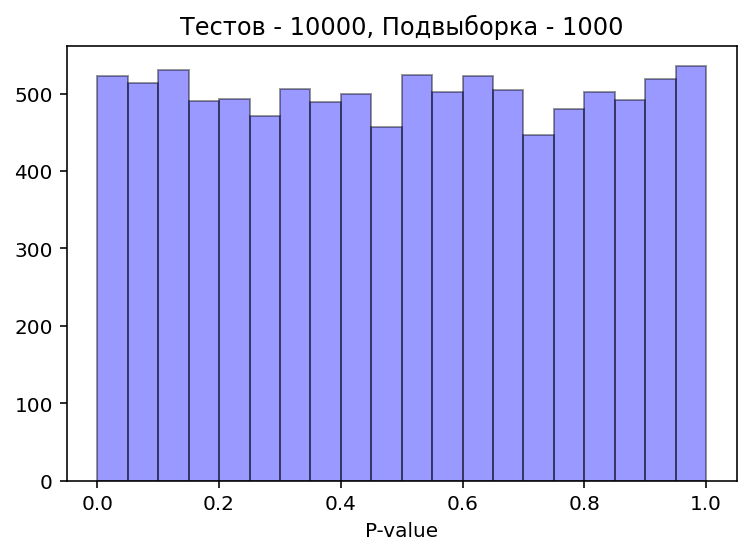

In [19]:
check_split_MW(n_samples = 1000, n_tests = 10000)

 Прокрас AA-теста:  5.08 %


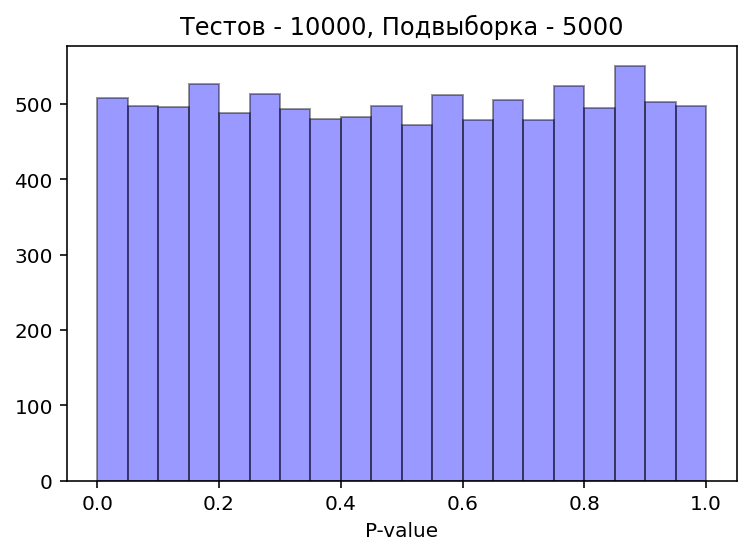

In [20]:
check_split_MW(n_samples = 5000, n_tests = 10000)

При использовании теста Манна-Уитни видим, что изменение процента прокраса АА-теста при увеличении количества сэмплов незначительное.